In [1]:

# Charge of electron in natural units (e = 1)
e_charge = -1.0
# Mass of electron in natural units (me = 511 keV/c^2)
e_mass = 511e3  # in eV

# Charge and mass of proton in natural units
p_charge = 1.0
p_mass = 938.272e6  # in eV

# Charge and mass of neutron in natural units
n_charge = 0.0
n_mass = 939.565e6  # in eV

# Mass of pion in natural units
pi_mass = 139.57018e6  # in eV

# Mass of muon in natural units
mu_mass = 105.6583745e6  # in eV

In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from Classes.Simulators import RK4_sim_dz, dz_propagator
from Classes.magnetic_field import MagneticField, Quadratic_Field, LHCb_Field
data = 'Data/twodip.rtf'
Qfield = Quadratic_Field(1e-7)
LHCbField = LHCb_Field(data)


def RK4_h(s : dict, z : float):
    """ Example ODE: du/dt = -u """
    return 


def compute_state_derivative(z,state,B):
    """Compute the derivative of the state vector using the Lorentz force"""

    # print(f' B field vector values: {B} | B field strength : {self.field.field_strength(B)}')

    x = state['x']
    y = state['y']
    tx = state['tx']
    ty = state['ty']
    q_over_p = state['q/p']
    dx = tx
    dy = ty
    dtx = q_over_p * np.sqrt(1 + tx**2 + ty**2) * (ty*(tx*B[0] + B[2]) - (1 + tx**2)*B[1])
    dty = -q_over_p * np.sqrt(1 + tx**2 + ty**2) * (tx*(ty*B[1] + B[2]) - (1 + ty**2)*B[0])
    return {'x': dx, 'y': dy, 'tx': dtx, 'ty': dty, 'q/p': 0}

def rk4_step(state,dz,field):
    """Perform a single RK4 step to update the particles' positions and momenta"""
    z = state[2]
    state = {'x': state[0], 'y': state[1], 'tx': state[3], 'ty': state[4], 'q/p': state[5]}

    # Compute k1
    k1 = compute_state_derivative(z,state,field.interpolated_field(state['x'], state['y'], z))

    # Compute k2
    state_k2 = {key: state[key] + 0.5 * dz * k1[key] for key in state}
    k2 = compute_state_derivative(z, state_k2,field.interpolated_field(state['x'], state['y'], z + 0.5 * dz))

    # Compute k3
    state_k3 = {key: state[key] + 0.5 * dz * k2[key] for key in state}
    k3 = compute_state_derivative(z, state_k3, field.interpolated_field(state['x'], state['y'],z + 0.5 * dz))

    # Compute k4
    state_k4 = {key: state[key] + dz * k3[key] for key in state}
    k4 = compute_state_derivative(z, state_k4, field.interpolated_field(state['x'], state['y'],z + dz))

    # Convert dictionary values to tensors
    k1_tensor = torch.tensor([k1['x'], k1['y'], k1['tx'], k1['ty']], dtype=torch.float32)
    k2_tensor = torch.tensor([k2['x'], k2['y'], k2['tx'], k2['ty']], dtype=torch.float32)
    k3_tensor = torch.tensor([k3['x'], k3['y'], k3['tx'], k3['ty']], dtype=torch.float32)
    k4_tensor = torch.tensor([k4['x'], k4['y'], k4['tx'], k4['ty']], dtype=torch.float32)

    return torch.stack([k1_tensor, k2_tensor, k3_tensor, k4_tensor]).flatten()

# state = {'x' : 0, 'y' : 0, 'z' : 0, 'tx' : 0, 'ty' : 0, 'q/p' : -1/np.linalg.norm([0, 0, 0.99 * e_mass])}
z = 0
dz = 1
field = Qfield

# rk4_step(state,dz,field)

In [3]:
import numpy as np
import pandas as pd

# Define grid bounds
X = 10  # Example max x value
Y = 10  # Example max y value
Z0 = 0  # Example min z value
Zt = 10  # Example max z value

# Define number of points
num_points = 100000

# Generate grid points
x_vals = np.random.uniform(-4000,4000,num_points)
y_vals = np.random.uniform(-4000,4000,num_points)
z_vals = np.random.uniform(-500,14000,num_points)

# Generate normal distributed tx, ty
tx_vals = np.random.normal(loc=0, scale=1, size=num_points)
ty_vals = np.random.normal(loc=0, scale=1, size=num_points)

# Compute q/p
e_mass = 0.511e-3  # Electron mass in GeV/c^2
q_p = -1 / np.linalg.norm([0, 0, 0.99 * e_mass])

data = pd.DataFrame({
    'x': x_vals[:num_points],
    'y': y_vals[:num_points],
    'z': z_vals[:num_points],
    'tx': tx_vals,
    'ty': ty_vals,
    'q/p': q_p
})



In [4]:
data.to_csv('simulated_data_for_pinn')

In [29]:
data = pd.read_csv('simulated_data_for_pinn').iloc[:,1:]

In [131]:
# Define the neural network to approximate u(t)
class NeuralNet(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=10, output_dim=16):
        super(NeuralNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self,s):
        return self.model(s)


In [46]:
data

,x,y,z,tx,ty,q/p
0,545.620573,-234.514576,492.025261,-0.886899,0.008703,-1976.714305
1,-2183.695518,3547.132023,820.973682,0.440578,-0.673714,-1976.714305
2,-3784.327395,-770.850134,12419.048153,-0.566501,2.007952,-1976.714305
3,-3271.009612,1287.513601,11094.789524,-1.948198,1.090064,-1976.714305
4,-1631.224949,-1091.172105,3791.099341,0.066436,-1.072967,-1976.714305
...,...,...,...,...,...,...
99995,2790.206430,2090.770078,6733.867761,-1.282664,-1.605547,-1976.714305
99996,-3423.536421,-2410.039459,8065.309214,1.791456,1.796481,-1976.714305
99997,511.786231,-2878.180660,12332.503379,1.182798,-0.141591,-1976.714305
99998,803.526748,-362.746290,12326.541591,-0.896710,0.524572,-1976.714305


In [127]:
def epsilon(model, s, dz = 1):
    """
    Computes the Runge-Kutta residual loss for a neural network approximating u(t).
    
    Parameters:
    - model: Neural network representing u(t).
    - t: Current time step.
    - h: Step size.
    
    Returns:
    - Residual loss enforcing the Runge-Kutta constraints.
    """
    
    # Compute k1, k2, k3, k4 using autodiff
    h_ = model(s)

    h = rk4_step(s,dz,field)
    
    print(f'h_ : {h_} , h : {h}')
    assert h.shape == h_.shape
    
    # Compute loss: enforce that u_pred should match u(t + h)
    loss = torch.mean(torch.norm(h - h_) ** 2)
    
    return loss


In [132]:
# Initialize neural network
# Initialize neural network
model = NeuralNet()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training parameters
epochs = 5000
states = pd.read_csv('simulated_data_for_pinn').iloc[:,1:]

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Ensure loss is a tensor
    loss = torch.tensor(0.0, requires_grad=True)

    for _, s in states.iterrows():  # Iterate over rows properly
        s_tensor = torch.tensor(s.values, dtype=torch.float32)  # Convert to tensor
        loss += epsilon(model, s_tensor)  # Ensure all inputs are tensors
    
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


h_ : tensor([-0.1636, -0.0778,  0.4959,  0.1732,  0.5461, -0.5875,  0.3427, -0.3526,
        -0.1235, -0.4873,  0.4155, -0.1484, -0.0689,  0.3650,  0.1265, -0.2485],
       grad_fn=<ViewBackward0>) , h : tensor([-8.8690e-01,  8.7026e-03, -9.3311e+06,  5.2409e+06, -4.6655e+06,
         2.6205e+06, -7.0841e+26,  3.9789e+26, -3.5421e+26,  1.9894e+26,
               -inf,         inf,        -inf,         inf,        -inf,
                inf])


C:\Users\GeorgeWilliam\AppData\Local\Temp\ipykernel_49912\2818067845.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dtx = q_over_p * np.sqrt(1 + tx**2 + ty**2) * (ty*(tx*B[0] + B[2]) - (1 + tx**2)*B[1])
C:\Users\GeorgeWilliam\AppData\Local\Temp\ipykernel_49912\2818067845.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dty = -q_over_p * np.sqrt(1 + tx**2 + ty**2) * (tx*(ty*B[1] + B[2]) - (1 + ty**2)*B[0])


RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

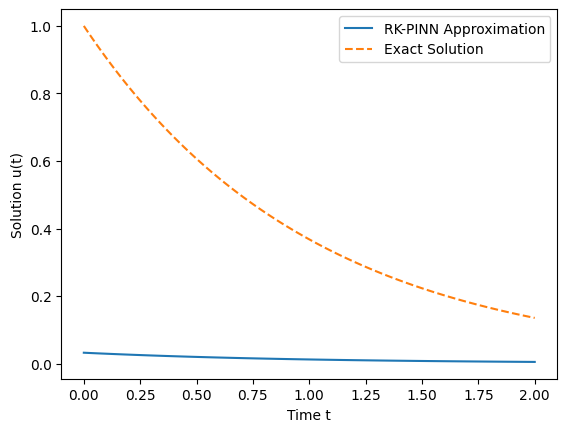

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

t_test = torch.linspace(0, 2, 100).view(-1, 1)
u_pred = model(t_test).detach().numpy()
u_exact = np.exp(-t_test.numpy())

plt.plot(t_test.numpy(), u_pred, label="RK-PINN Approximation")
plt.plot(t_test.numpy(), u_exact, label="Exact Solution", linestyle="dashed")
plt.legend()
plt.xlabel("Time t")
plt.ylabel("Solution u(t)")
plt.show()
